<a href="https://colab.research.google.com/github/sayakpaul/Learnable-Image-Resizing/blob/main/Learnable_Resizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZMPD2X/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding="same",
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x

In [12]:
def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

In [13]:
inputs = tf.random.normal((32, 28, 28, 16))
res_block(inputs).shape

TensorShape([32, 28, 28, 16])

In [30]:
INP_DIM = (300, 300)
TARGET_DIM = (224, 224)
INTERPOLATION = "bilinear"

In [31]:
def learnable_resizer(inputs, 
    filters=16,
    num_res_blocks=1, 
    interpolation=INTERPOLATION):

    # We first need to resize to a fixed resolution to allow mini-batch learning
    naive_resize = layers.experimental.preprocessing.Resizing(*TARGET_DIM,
            interpolation=interpolation)(inputs)

    # First conv block without Batch Norm
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second conv block with Batch Norm
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as bottleneck
    bottleneck = layers.experimental.preprocessing.Resizing(*TARGET_DIM,
            interpolation=interpolation)(x)
    
    # Residual passes
    for _ in range(num_res_blocks):
        x = res_block(bottleneck)

    # Projection
    x = layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding="same",
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    x = layers.Add()([bottleneck, x])

    # Final resized image
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return final_resize

In [33]:
random_inputs = tf.random.normal((32, 326, 500, 3))
random_inputs = tf.image.resize(random_inputs, size=INP_DIM)
learnable_resizer(random_inputs).shape

TensorShape([32, 224, 224, 3])

In [34]:
!wget -q https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg

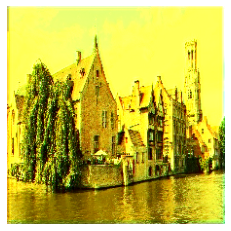

In [36]:
image = tf.io.read_file("belfry-2611573_1280.jpg")
image = tf.image.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
resized = learnable_resizer(image[None, ...])

plt.imshow(np.clip(resized.numpy().squeeze(), 0., 1.))
plt.axis("off")
plt.show()